# Подготовка данных пациентов

In [277]:
# standard
import pandas as pd
import numpy as np
import re
import seaborn as sbs
import matplotlib.pyplot as plt
import matplotlib
from tqdm import notebook
sbs.set_style("darkgrid")

# text processing
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem

# preprocessing/processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_validate,  StratifiedKFold
import imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import recall_score, f1_score, precision_score

# base models
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model building
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Загрузка данных

In [2]:
file_path = 'chd_addmit_300.xlsx'

In [3]:
patient_data = pd.read_excel(file_path)

In [4]:
patient_data.head()

,admittion,discharge,sex,height,weight,BMI,BSA,birth,Операции (все в ИБ),Перенесенные опер. (из Анамн.),...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2016-12-12,2017-01-10,m,76,9.70,111.27,0.46,02.01.2016,12.12.2016: (Откр./ИК) Перевязка ранее наложен...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-13,2017-02-01,f,67,7.34,89.67,0.37,02.02.2016,18.01.2017: (Откр./ИК) Радикальная коррекция д...,15.08.2016г.: Транслюминальная балонная вальву...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-17,2017-02-09,m,74,8.90,103.46,0.43,21.02.2016,19.01.2017: (Откр./ИК) Перевязка ранее наложен...,29.02.2016 - подключично-легочный анастомоз сп...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-20,2017-02-21,f,67,6.97,85.15,0.36,02.03.2016,23.01.2017: (Откр./ИК) Наложение двустороннего...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-13,2017-03-01,m,82,9.29,102.59,0.46,08.03.2016,15.02.2017: (Откр./ИК) Реконструкция путей отт...,13.04.2016. НАЗВАНИЕ ОПЕРАЦИИ: Транслюминальна...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   admittion                                        300 non-null    datetime64[ns]
 1   discharge                                        300 non-null    datetime64[ns]
 2   sex                                              300 non-null    object        
 3   height                                           300 non-null    int64         
 4   weight                                           300 non-null    float64       
 5   BMI                                              298 non-null    float64       
 6   BSA                                              298 non-null    float64       
 7   birth                                            300 non-null    object        
 8   Операции (все в ИБ)                     

In [6]:
patient_data.describe()

,height,weight,BMI,BSA,target,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
count,300.000000,300.000000,298.000000,298.000000,300.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,64.890000,6.293560,76.834430,0.336477,0.046667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.076012,1.951695,20.640196,0.073846,0.211276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,39.000000,1.270000,20.340000,0.120000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,60.000000,4.868500,62.007500,0.280000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65.500000,6.442500,78.430000,0.350000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,71.000000,7.651250,91.797500,0.390000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,85.000000,12.000000,137.650000,0.520000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Успешно создан датасет. Необходимо изменить тип данных некоторых признаков, убрать пропуски.

## Предобработка

### Main dataset

In [293]:
main_dataset = pd.DataFrame()

In [297]:
main_dataset[['sex',
              'height',
              'weight',
              'BMI','BSA',
              'operations',
              'echo',
              'target']] = patient_data[['sex',
                                         'height',
                                         'weight',
                                         'BMI',
                                         'BSA',
                                         'Операции (все в ИБ)',
                                         'ЭКГ (Из Эпикр. до опер.)',
                                         'target']]

### Уберем пропуски

In [298]:
main_dataset.isnull().sum()

sex            0
height         0
weight         0
BMI            2
BSA            2
operations     0
echo          20
target         0
dtype: int64

In [299]:
main_dataset = main_dataset.dropna()

In [300]:
main_dataset.isnull().sum()

sex           0
height        0
weight        0
BMI           0
BSA           0
operations    0
echo          0
target        0
dtype: int64

### Обработка текста

In [17]:
m = Mystem()

# Леммантизирует текст
def lemmatize(text):
    return "".join(m.lemmatize(text))

def clear_text(text):
    cleaned = re.sub(r'[^а-яА-Яa-zA-ZёЁ ]', ' ', text)
    cleaned = cleaned.split()
    return ' '.join(cleaned)

In [327]:
%%time

main_dataset['operations'] = main_dataset['operations'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: total: 656 ms
Wall time: 4min 6s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [328]:
%%time

main_dataset['echo'] = main_dataset['echo'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: total: 1.19 s
Wall time: 8min 14s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [329]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,echo,target
172,0,58,6.550,86.01,0.33,откр ик устранение перерыв дуга аорта с помощь...,экг ритм сердце синусовый частота сердцебиение...,0
259,1,63,4.700,59.21,0.29,закрывать резекция коарктация аорта с наложени...,ритм синусовый ЧСС в мина эос отклонять вправо...,0
234,0,47,2.670,38.95,0.19,эндоваск транслюминальный балонный ангиопласти...,ритм синусовый вертикальный положение эос ЧСС ...,0
37,0,69,7.595,91.43,0.38,откр ик радикальный коррекция двойной отхожден...,ритм синусовый правильный с частота удар в мин...,0
85,1,70,7.750,92.63,0.39,закрывать гибридный трансвентрикулярный балонн...,экг ритм сердце синусовый частота сердцебиение...,0


### Категории

In [302]:
main_dataset['sex'] = pd.get_dummies(main_dataset['sex'], drop_first=True)

C:\TEMP\ipykernel_6196\1804677275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset['sex'] = pd.get_dummies(main_dataset['sex'], drop_first=True)


In [376]:
main_dataset = main_dataset.drop('echo', axis=1)

In [377]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,target
160,0,76,7.360,84.42,0.40,откр ик ушивание ранее налагать центральный ан...,0
215,1,55,3.844,51.83,0.24,откр ик расширение мпс перемещение коллектор Л...,0
68,1,65,7.100,88.06,0.36,закрывать наложение модифицированный подключич...,0
207,1,69,7.580,91.25,0.38,откр ик вальвулопластик клапан легочный артери...,0
140,0,55,5.172,69.74,0.28,эндоваск транслюминальный балонный вальвулопла...,0


### Обучение

#### Text Features Pipeline

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Стивен\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stopwords = nltk_stopwords.words('russian')

In [25]:
operations_transformer = TfidfVectorizer(stop_words=stopwords)

In [136]:
num_features = ['height', 'weight', 'BMI', 'BSA']

In [137]:
num_transformer = StandardScaler()

#### Column Transformer

In [371]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', operations_transformer, 'operations'),
        #('echo', operations_transformer, 'echo'),
        ('num', num_transformer, num_features)
    ],
    remainder='passthrough'
)

In [378]:
preprocessor.fit_transform(main_dataset).shape

(278, 257)

In [379]:
X, y = main_dataset.drop(['target'], axis=1), main_dataset['target']

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [381]:
X_train.shape

(194, 6)

In [382]:
X_test.shape

(84, 6)

In [383]:
y_train.value_counts()

0    185
1      9
Name: target, dtype: int64

In [365]:
y_test.value_counts()

0    80
1     4
Name: target, dtype: int64

### Выбор модели

Сделаем пайплайн на примере кэтбуст. Проверим на кросс валидации

### Pipeline + RandomSearch

In [384]:
def create_pipeline(clf):
    pipeline = imbpipeline(
        steps=[
            ('preprocess', preprocessor),
            ('undersampler', RandomUnderSampler(sampling_strategy=0.2)),
            ('smote', SMOTE()),
            ('clf', clf)
        ]
    )
    return pipeline

In [385]:
def random_search(clf, params, n_iter=10):
    clf = create_pipeline(clf)
    return RandomizedSearchCV(clf,
                              params,
                              scoring='neg_log_loss',
                              n_jobs=-1,
                              n_iter=n_iter,
                              cv=StratifiedKFold(n_splits=3, shuffle=True),
                              verbose=5
                             )

In [386]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def thresholds_argmax(model, x, y):
    thresholds = np.arange(0, 0.9, 0.001)
    probs = model.predict_proba(x)[:, 1]
    scores = [roc_auc_score(y, to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    threshold = thresholds[ix]
    return (threshold)

In [387]:
def fit_data(model, show_feature_importance=False):
    clf_name = model.estimator['clf'].__class__.__name__
    print(f'Classifier name: {clf_name}')
    
    model = model.fit(X_train, y_train)
    print(f'Training finished!', '-'*100, sep='\n')
    print(f'Best score: = {model.best_score_}')
    print(f'Best parameters {model.best_params_}')
    
    if show_feature_importance:   
        try:
            if clf_name == 'CatBoostClassifier':
                feature_importance = model.best_estimator_['clf'].get_feature_importance()
            elif clf_name == 'XGBClassifier':
                feature_importance = model.best_estimator_['clf'].feature_importances_
            else:
                feature_importance = feature_importance = model.best_estimator_['clf'].feature_importance_
            main_features = pd.DataFrame(data = feature_importance[-5:], index=X.columns[:5]).sort_values(by=0)
            
            plt.figure(figsize=(10, 7))
            main_features.plot(kind='barh', ax=plt.gca())
            plt.title('Feature Importance without operations')
            plt.xlabel('Importance, %')
            plt.show()
        except:
            print('no feature importance')
    
    best_model = model.best_estimator_.fit(X_train, y_train)
    th = thresholds_argmax(best_model, X_test, y_test)
    print(f'Threshold: {th}')
    predictions = best_model.predict_proba(X_test)[:,1] > th
    print(f'Confusion Matrix:\n {confusion_matrix(y_test, predictions)}')
    print(classification_report(y_test, predictions))
    f1 = f1_score(y_test, predictions, labels=[1])
    precision = precision_score(y_test, predictions, labels=[1])
    recall = recall_score(y_test, predictions, labels=[1])
    
    return best_model, th, abs(model.best_score_), f1, precision, recall

### Перебор моделей

In [388]:
def look_through_models(models):
    names = []
    best_models = []
    data_list = []
    for model in notebook.tqdm(models):
        data = fit_data(model)
        names.append(data[0]['clf'].__class__.__name__)
        best_models.append(data[0])
        data_list.append(data[1:])
        print('_'*100)
    
    data_df = pd.DataFrame(data=data_list, index=names)
    display(data_df)
    data_df[0].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('Threshold')
    plt.show()
    data_df[1].sort_values(0, ascending=False).plot(kind='barh', ax=plt.gca())
    plt.xlabel('Log loss score')
    plt.show()
    data_df[2].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('f1 score')
    plt.show()
    data_df[3].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('precision score')
    plt.show()
    data_df[4].sort_values(0).plot(kind='barh', ax=plt.gca())
    plt.xlabel('recall score')
    plt.show()
    
    return best_models

#### Models

In [389]:
models = []

In [390]:
#Tree
parameters = {
    'clf__max_depth': range(3, 10),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(DecisionTreeClassifier(),
                          parameters,
                          70)
models.append(svc)

In [391]:
#SGD
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(SGDClassifier(loss='log_loss'),
                          parameters,
                          30)
models.append(svc)

In [392]:
#KNN
parameters = {
    'clf__n_neighbors': range(3, 10),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(KNeighborsClassifier(),
                          parameters,
                          60)
models.append(svc)

In [393]:
#Forest
parameters = {
    'clf__max_depth': range(3, 10),
    'clf__n_estimators': range(200, 2000, 200),
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(RandomForestClassifier(),
                          parameters,
                          120)
models.append(svc)

In [394]:
#Logistic
parameters = {
    'clf__C': [.1, 1, 10, 100, 1000],
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(LogisticRegression(),
                          parameters,
                          90)
models.append(svc)

In [395]:
#SVC
parameters = {
    'clf__gamma': [.1,.5,1,2,5,10],
    'clf__C': [.1, 1, 10, 100, 1000],
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1)
}

svc = random_search(SVC(probability=True, kernel='rbf'),
                          parameters,
                          90)
models.append(svc)

In [396]:
#CatBoost
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__depth': range(2, 11),
}

catboost_search = random_search(CatBoostClassifier(silent=True, iterations=750),
                                       parameters,
                                       80)
models.append(catboost_search)

In [397]:
#XGB
parameters = {
    'preprocess__text__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'preprocess__text__max_df': (0.25, 0.5, 0.75, 1.0),
    'smote__sampling_strategy': np.arange(0.2, 0.8, 0.1),
    'clf__max_depth': range(2, 11),
}

xgb_search = random_search(XGBClassifier(),
                          parameters,
                          80)
models.append(xgb_search)

#### Results

  0%|          | 0/8 [00:00<?, ?it/s]

Classifier name: DecisionTreeClassifier
Fitting 3 folds for each of 70 candidates, totalling 210 fits
Training finished!
----------------------------------------------------------------------------------------------------
Best score: = -1.1151814735499077
Best parameters {'smote__sampling_strategy': 0.6000000000000001, 'preprocess__text__ngram_range': (1, 1), 'preprocess__text__max_df': 0.25, 'clf__max_depth': 3}
Threshold: 0.075
Confusion Matrix:
 [[79  1]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        80
           1       0.67      0.50      0.57         4

    accuracy                           0.96        84
   macro avg       0.82      0.74      0.78        84
weighted avg       0.96      0.96      0.96        84

____________________________________________________________________________________________________
Classifier name: SGDClassifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training

,0,1,2,3,4
DecisionTreeClassifier,0.075,1.115181,0.571429,0.666667,0.5
SGDClassifier,0.002,0.691285,0.266667,0.181818,0.5
KNeighborsClassifier,0.201,0.796105,0.166667,0.100000,0.5
RandomForestClassifier,0.102,0.157175,0.421053,0.266667,1.0
LogisticRegression,0.079,0.186964,0.347826,0.210526,1.0
SVC,0.028,0.194382,0.186047,0.102564,1.0
CatBoostClassifier,0.036,0.175642,0.307692,0.181818,1.0
XGBClassifier,0.058,0.216716,0.571429,0.400000,1.0


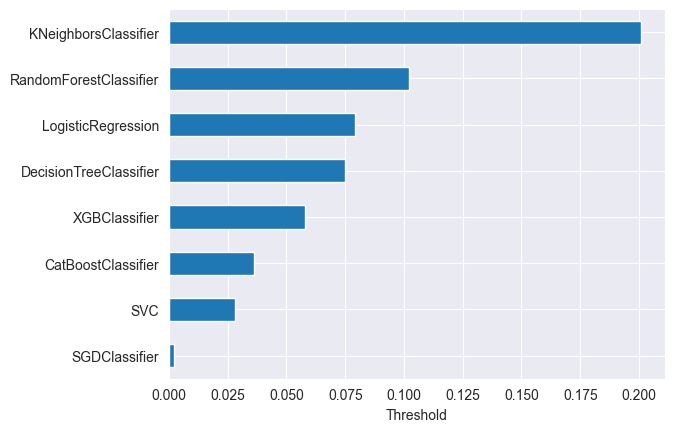

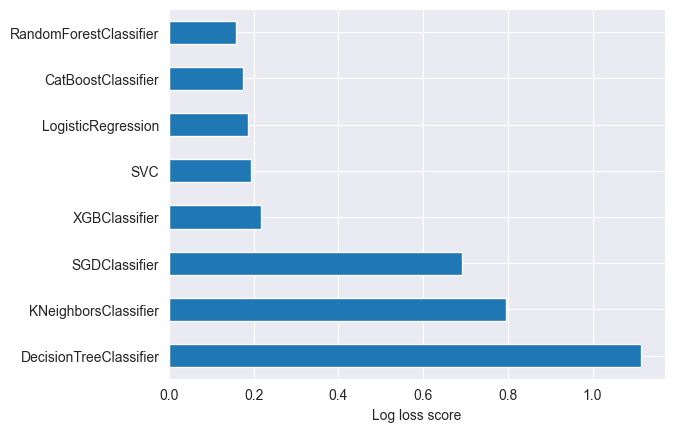

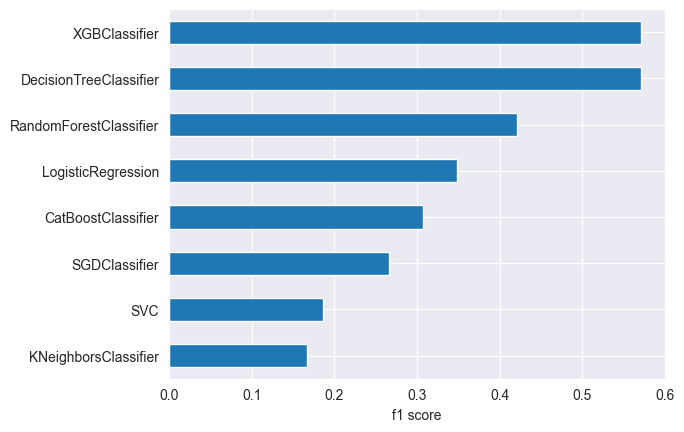

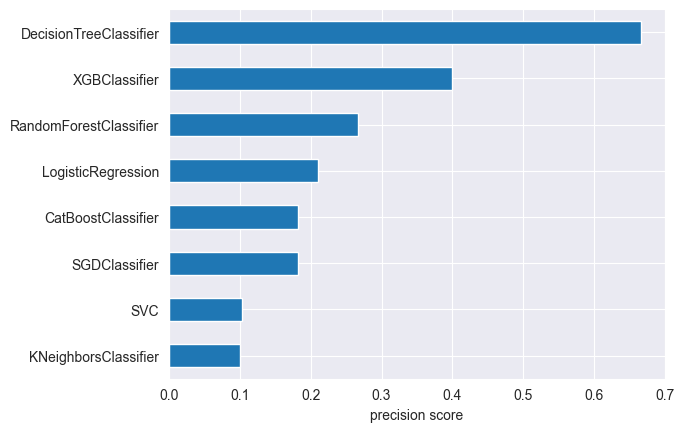

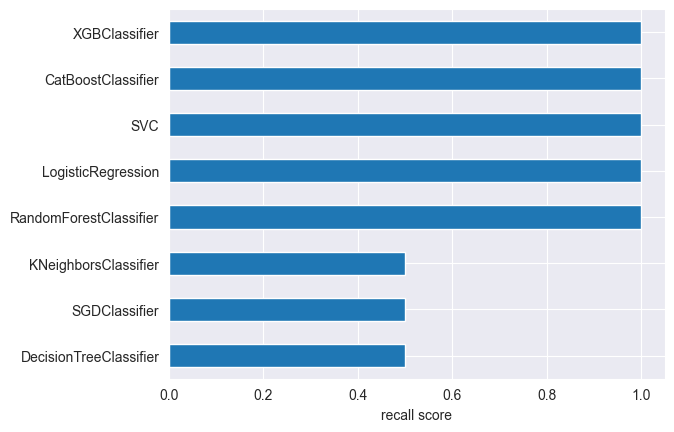

In [398]:
look_through_models(models);